In [16]:
import matplotlib.pyplot as plt
import glob
from datetime import datetime

import numpy as np

import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.map

from my_reproject import reproject_to_aia, plot_reproject

In [2]:
aia_path='data/AIA/aia_lev1_304a_2011_01_27t22_58_56_12z_image_lev1.fits'
euvi_path='data/SECCHI/20110127_164845_n5eua.fts'

map_aia=sunpy.map.Map(aia_path)
map_euvi=sunpy.map.Map(euvi_path)

out_shape = (512, 512)
map_aia = map_aia.resample(out_shape * u.pix)
map_euvi = map_euvi.resample(out_shape * u.pix)

## Basic info

### AIA

Observatory,SDO
Instrument,AIA 4
Detector,AIA
Measurement,304.0 Angstrom
Wavelength,304.0 Angstrom
Observation Date,2011-01-27 22:58:56
Exposure Time,2.902162 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.600165 0.600165] arcsec / pix
Reference Pixel,[2053.260986 2023.139771] pix

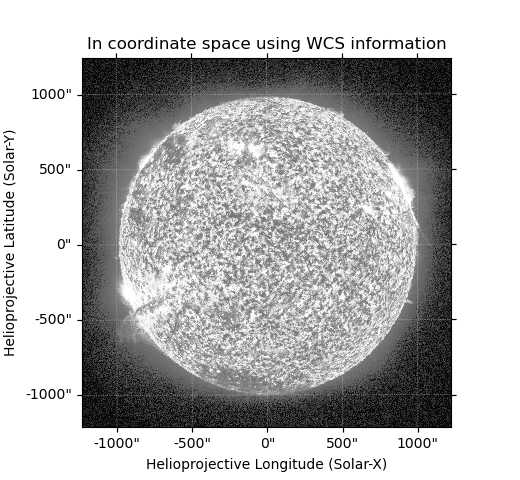
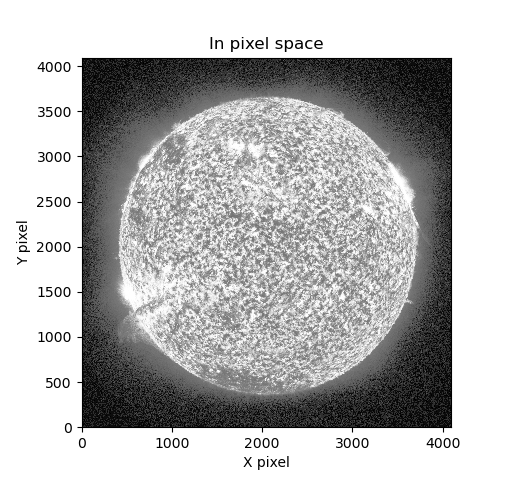
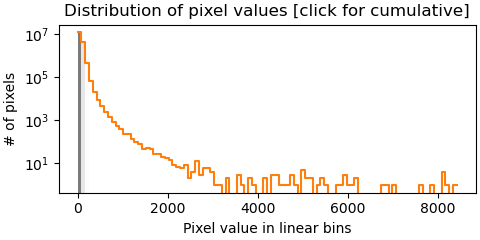
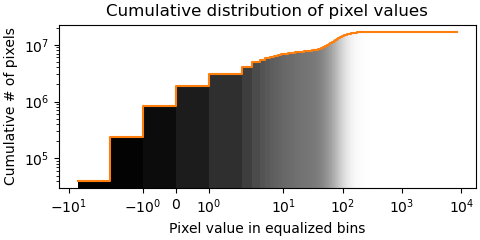

In [27]:
map_aia

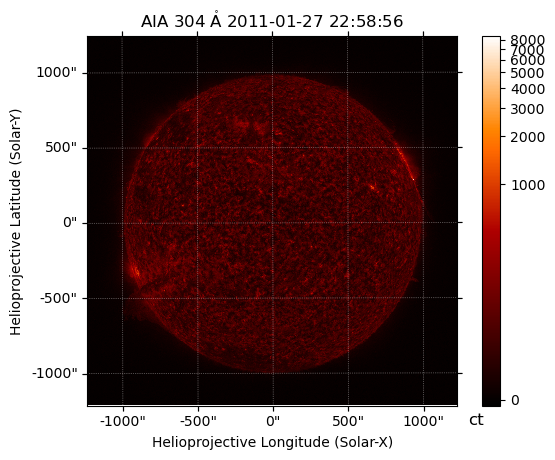

In [28]:
map_aia.peek()

### EUVI

Observatory,STEREO A
Instrument,SECCHI
Detector,EUVI
Measurement,304.0 Angstrom
Wavelength,304.0 Angstrom
Observation Date,2011-01-27 16:48:45
Exposure Time,4.00205 s
Dimension,[2048. 2048.] pix
Coordinate System,helioprojective
Scale,[1.58777404 1.58777404] arcsec / pix
Reference Pixel,[1020.81 925.284] pix

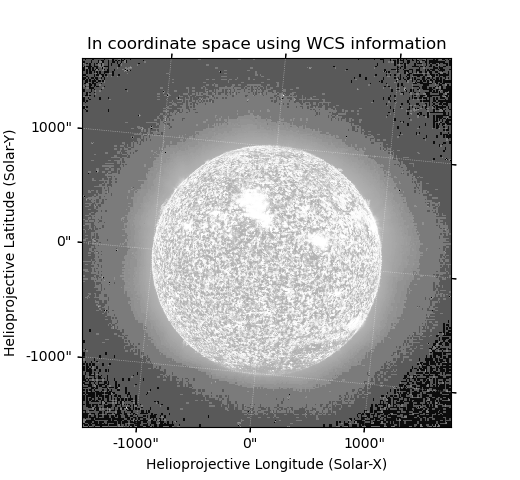
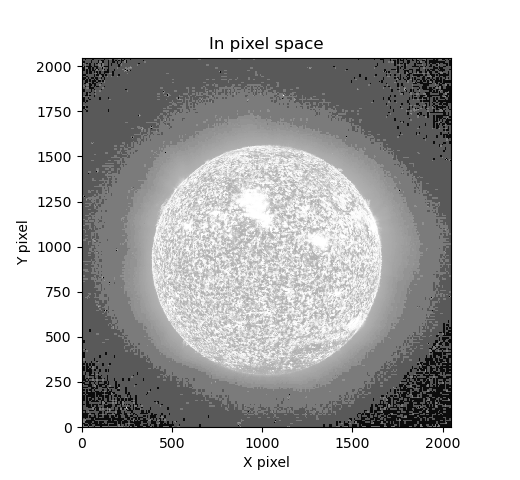
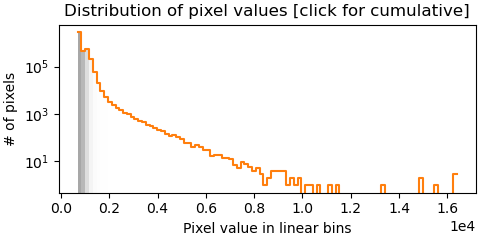
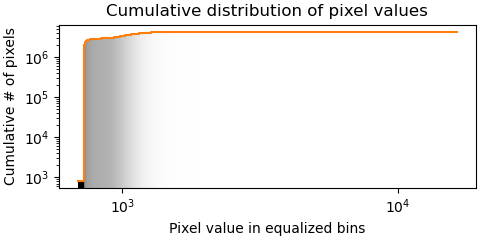

In [29]:
map_euvi

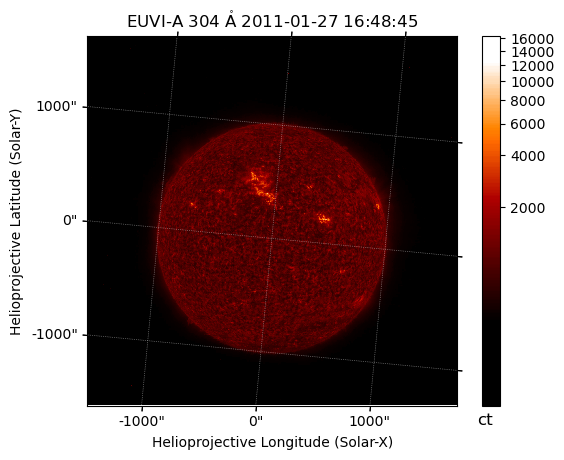

In [30]:
map_euvi.peek()

## EUVI image seen from SDO

Plot the two maps, with the solar limb as seen by each observatory
overlaid on both plots.



In [40]:
map_euvi.meta['rsun_obs']=974.634085
#'rsun_obs', 974.634085

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


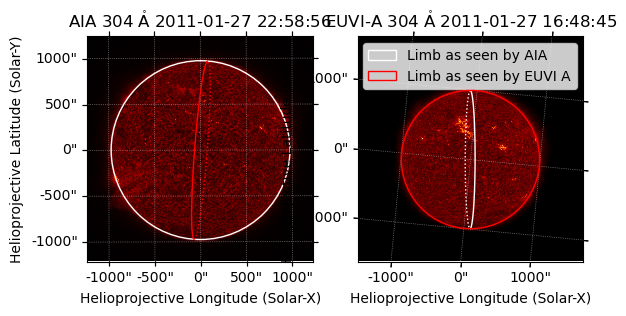

In [17]:
fig = plt.figure()

ax1 = fig.add_subplot(121, projection=map_aia)
map_aia.plot(axes=ax1)
map_aia.draw_limb(axes=ax1, color='white')
map_euvi.draw_limb(axes=ax1, color='red')

ax2 = fig.add_subplot(122, projection=map_euvi)
map_euvi.plot(axes=ax2)
limb_aia = map_aia.draw_limb(axes=ax2, color='white')
limb_euvi = map_euvi.draw_limb(axes=ax2, color='red')

plt.legend([limb_aia[0], limb_euvi[0]],
           ['Limb as seen by AIA', 'Limb as seen by EUVI A'])

We can now plot the STEREO/EUVI image as seen from the position of SDO, next to the AIA image.

In [27]:
out_header = sunpy.map.make_fitswcs_header(
    out_shape,
    map_aia.reference_coordinate.replicate(rsun=map_euvi.reference_coordinate.rsun),
    scale=u.Quantity(map_aia.scale),
    instrument="EUVI",
    observatory="AIA Observer",
    wavelength=map_euvi.wavelength
)

We can now reproject the EUVI map to this output WCS header.
The :meth:`~sunpy.map.GenericMap.reproject_to` defaults to using
the fast :func:`reproject.reproject_interp` algorithm, but a different
algorithm can be specified (e.g., :func:`reproject.reproject_adaptive`).

In [33]:
outmap = map_euvi.reproject_to(out_header)
# outmap 

In [34]:
outmap.data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


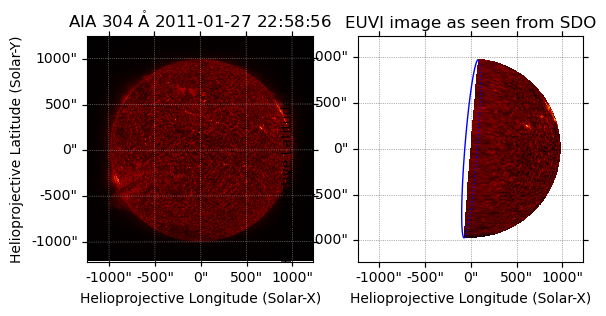

In [35]:
fig = plt.figure()
ax1 = fig.add_subplot(121, projection=map_aia)
map_aia.plot(axes=ax1)
ax2 = fig.add_subplot(122, projection=outmap)
outmap.plot(axes=ax2, title='EUVI image as seen from SDO')
map_euvi.draw_limb(color='blue')

# Set the HPC grid color to black as the background is white
ax2.coords[0].grid_lines_kwargs['edgecolor'] = 'k'
ax2.coords[1].grid_lines_kwargs['edgecolor'] = 'k'

## read STEREO files

### distinguish A and B

In [3]:
stereo_files = sorted(glob.glob('data/SECCHI/201101*.fts'))

In [46]:
stereo_files[0]

'data/SECCHI\\20110127_160115_n5eua.fts'

In [5]:
maps=sunpy.map.Map(stereo_files)

Observatory,STEREO A
Instrument,SECCHI
Detector,EUVI
Measurement,304.0 Angstrom
Wavelength,304.0 Angstrom
Observation Date,2011-01-27 16:01:15
Exposure Time,4.00205 s
Dimension,[2048. 2048.] pix
Coordinate System,helioprojective
Scale,[1.58777404 1.58777404] arcsec / pix
Reference Pixel,[1020.81 925.284] pix

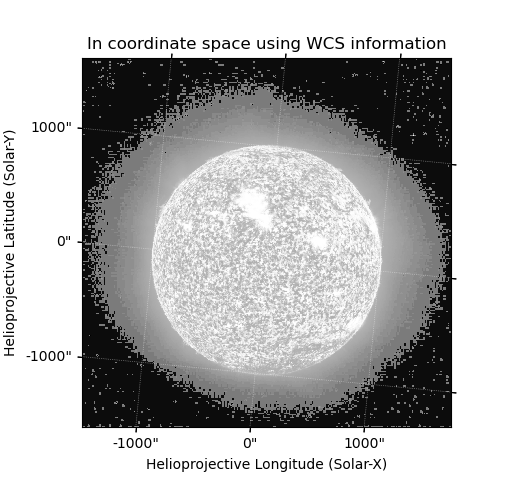
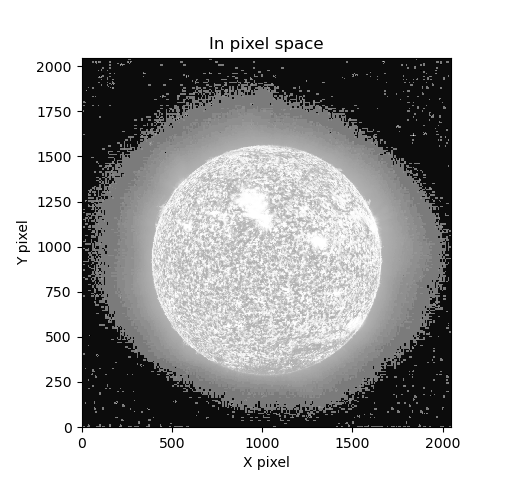
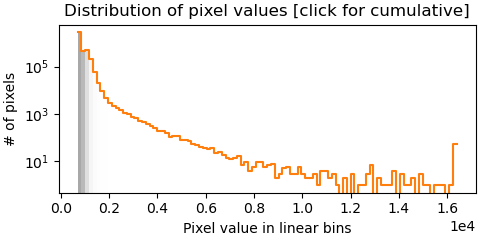
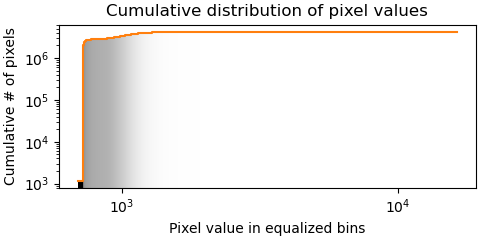

In [48]:
maps[0]

In [ ]:
maps[0].meta

In [ ]:
maps[0].meta['obsrvtry']

In [ ]:
maps[0].meta['date-obs']

maps[0]

In [6]:
# distinguish fits files from stereo A and stereo B
stereo_a = [m for m in maps if m.meta['obsrvtry'] == 'STEREO_A']
stereo_b = [m for m in maps if m.meta['obsrvtry'] == 'STEREO_B']

Observatory,STEREO A
Instrument,SECCHI
Detector,EUVI
Measurement,304.0 Angstrom
Wavelength,304.0 Angstrom
Observation Date,2011-01-27 16:21:15
Exposure Time,4.00205 s
Dimension,[2048. 2048.] pix
Coordinate System,helioprojective
Scale,[1.58777404 1.58777404] arcsec / pix
Reference Pixel,[1020.81 925.284] pix

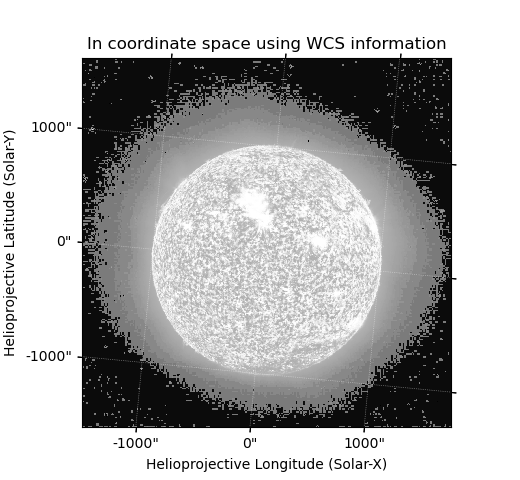
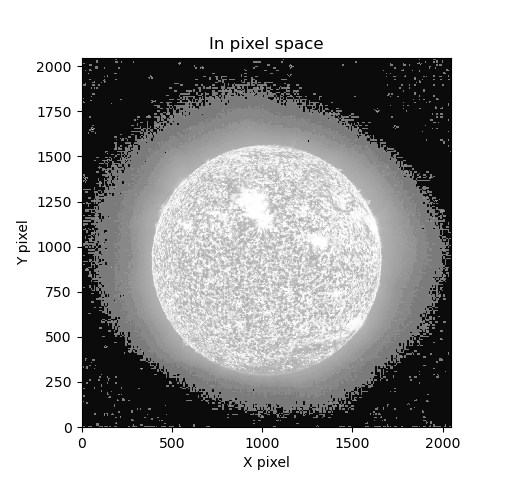
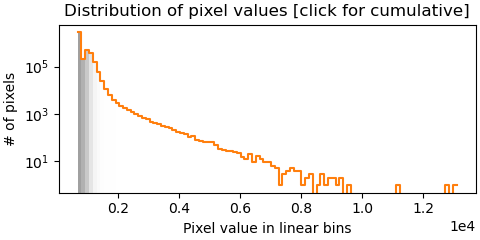
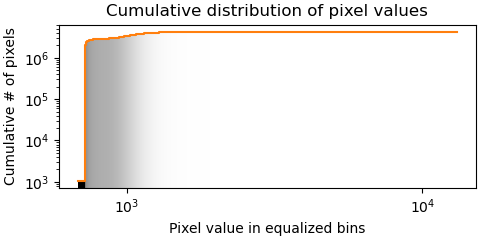

In [55]:
stereo_a[7]

In [ ]:
print(len(stereo_b))
for m in stereo_b:
    print(m.meta['date-obs'])

In [ ]:
type(m.meta['date-obs'])

In [ ]:
m.meta['date-obs']

In [ ]:
#transform the date-obs string into a datetime object
date_obs = datetime.strptime(m.meta['date-obs'], '%Y-%m-%dT%H:%M:%S.%f').minute
# I want to get minute from date_obs
date_obs

In [8]:
# x-axis: time  y-axis:irradiance
time=[]
irradiance_a=[]
for m in stereo_a:
    time.append( datetime.strptime(m.meta['date-obs'], '%Y-%m-%dT%H:%M:%S.%f')   )
    irradiance_a.append( np.nansum(m.data))
    
time_a=[]
for t in time:
    time_a.append(t.minute)


Text(0.5, 1.0, 'STEREO A')

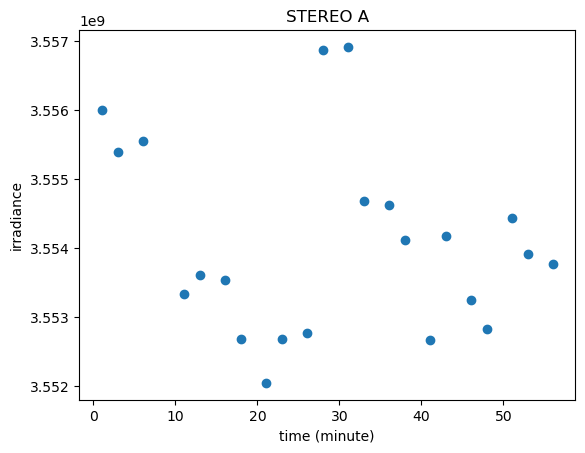

In [9]:
fig,ax=plt.subplots()
ax.scatter(time_a, irradiance_a, label='STEREO A')

ax.set_xlabel("time (minute)")
ax.set_ylabel("irradiance")
ax.set_title('STEREO A')

In [10]:
# x-axis: time  y-axis:irradiance
time=[]
irradiance_b=[]
for m in stereo_b:
    time.append( datetime.strptime(m.meta['date-obs'], '%Y-%m-%dT%H:%M:%S.%f')   )
    irradiance_b.append( np.nansum(m.data))
    
time_b=[]
for t in time:
    time_b.append(t.minute)

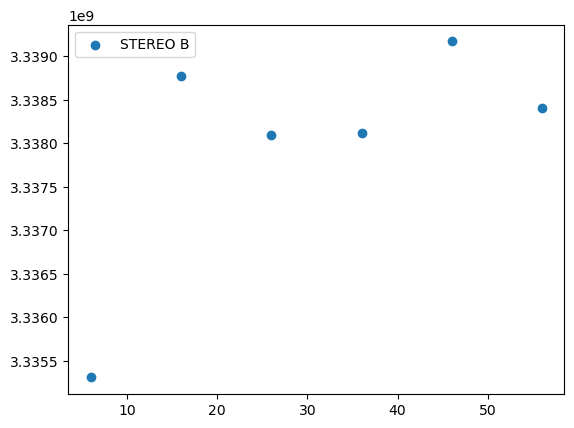

In [11]:
fig,ax=plt.subplots()
ax.scatter(time_b, irradiance_b, label='STEREO B')
ax.legend()

#### combine
此时并没有选择SDO视野部分的，而是STEREO视野作为示意

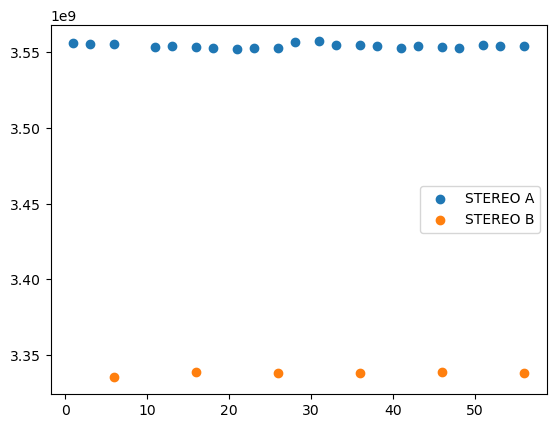

In [13]:
fig,ax=plt.subplots()
ax.scatter(time_a, irradiance_a,c='C0' ,label='STEREO A')

ax.scatter(time_b, irradiance_b,c='C1' ,label='STEREO B')
ax.legend()

### EUVI image seen from SDO

In [19]:
outmap=reproject_to_aia(map_aia,map_euvi,out_shape)

In [28]:
print(np.sum(map_euvi.data) )
print(np.sum(map_aia.data))
print(np.nansum(outmap.data))
print(np.nansum(outmap.data)/np.sum(map_euvi.data))

222058111.5
13036936.75
71184335.9440921
0.32056624936257777


Observatory,
Instrument,
Detector,
Measurement,Unknown
Wavelength,Unknown
Observation Date,2011-01-27 22:58:56
Exposure Time,Unknown
Dimension,[512. 512.] pix
Coordinate System,helioprojective
Scale,[0.0013337 0.0013337] deg / pix
Reference Pixel,[255.5 255.5] pix

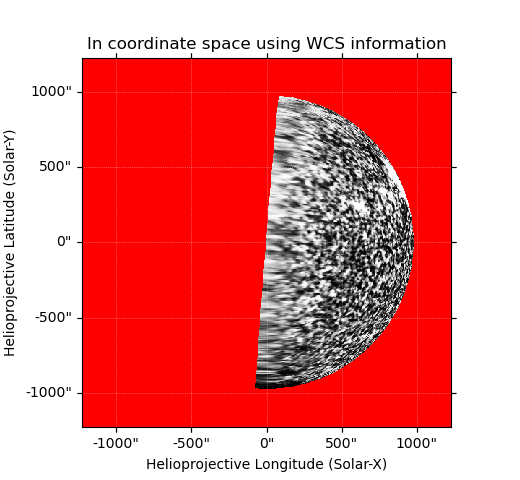
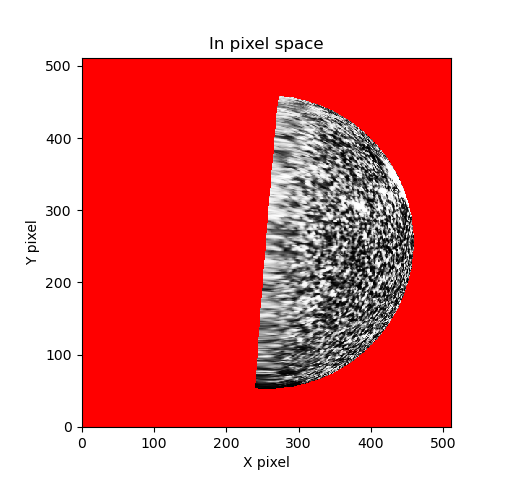
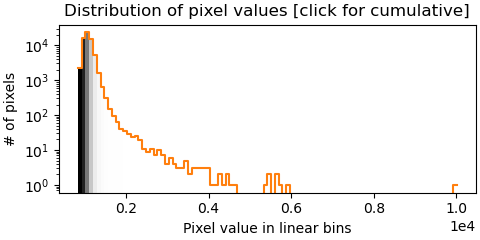
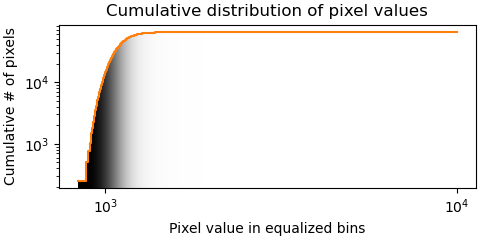

In [21]:
outmap

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


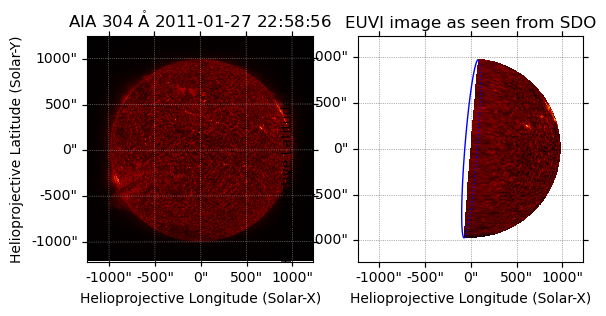

In [8]:
plot_reproject(map_aia,map_euvi,outmap)

### EUVI irradiance ~ time

#### A

In [14]:
irradiance_a=np.zeros(len(stereo_a))
irradiance_a

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [ ]:
len(stereo_a)

In [19]:
for i in range( len(stereo_a)):
    outmap=reproject(map_aia,stereo_a[i])
    irradiance_a[i]=np.nansum(outmap.data)

NameError: name 'reproject' is not defined

In [ ]:
irradiance_a

#### B

In [ ]:
irradiance_b=np.zeros(len(stereo_b))
irradiance_b

In [21]:
for i in range( len(stereo_b)):
    outmap=reproject_to_aia(map_aia,stereo_b[i])
    irradiance_b[i]=np.nansum(outmap.data)

TypeError: reproject_to_aia() missing 1 required positional argument: 'out_shape'

In [ ]:
irradiance_b

#### time

In [ ]:
time=[]
for m in stereo_a:
    time.append( datetime.strptime(m.meta['date-obs'], '%Y-%m-%dT%H:%M:%S.%f')   )
    
time_a=[]
for t in time:
    time_a.append(t.minute)
    
time=[]
for m in stereo_b:
    time.append( datetime.strptime(m.meta['date-obs'], '%Y-%m-%dT%H:%M:%S.%f')   )
    
time_b=[]
for t in time:
    time_b.append(t.minute)

In [ ]:
time_b

In [ ]:
irradiance_b

Text(0.5, 1.0, 'STEREO')

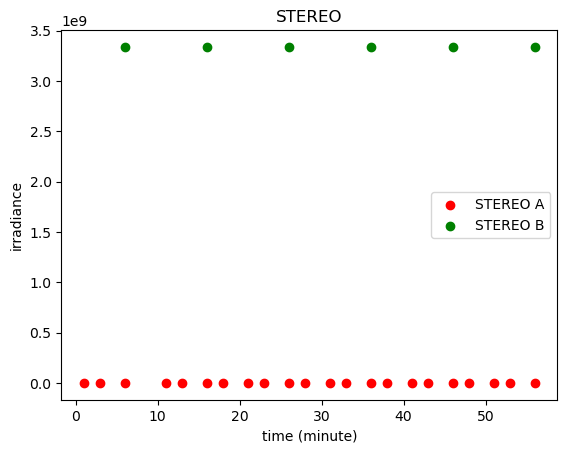

In [20]:
fig,ax=plt.subplots()
ax.scatter(time_a, irradiance_a, c='r',label='STEREO A')
ax.scatter(time_b, irradiance_b, c='g',label='STEREO B')  
    
ax.legend()
ax.set_xlabel("time (minute)")
ax.set_ylabel("irradiance")
ax.set_title('STEREO')

### sequence visualization

In [31]:
for i in range( len(stereo_a)):
    outmap=reproject(map_aia,stereo_a[i])
    plot_reproject(map_aia,outmap)

NameError: name 'reproject' is not defined

In [35]:
for i in range( len(stereo_b)):
    outmap=reproject_to_aia(map_aia,stereo_b[i],out_shape)
    plot_reproject(map_aia,outmap)

AttributeError: module 'reproject' has no attribute 'reproject_interp'